In [2]:
# Only run this once
import os
os.chdir('..')

In [34]:
import numpy as np
import scipy
from scipy import signal
import mne
import glob
import HiguchiFractalDimension as hfd
import csv
import matplotlib.pyplot as plt

import utils.logger
from utils.experiments_classification import classify_nusvm_cross_valid, classify_nusvm_param_seach

In [33]:
import importlib
importlib.reload(utils.experiments_classification)

<module 'utils.experiments_classification' from 'D:\\etc\\uni\\yr5\\project\\workspace\\eeg-cnp-final-year-project\\utils\\experiments_classification.py'>

In [5]:
def patient_array_to_hfd(repetitions, window_start=None, window_size=500, step_size=1, k=7):
    '''
    Apply HFD to all repetitions from given patient; input shape [n_repetitions, n_channels, n_features]
    '''
    if window_start != None:
        print('Calculating HFD with window start', str(window_start), 'window size', str(window_size), 'step', str(step_size))
        return np.array([np.array([[hfd.hfd(channel[window_start:window_start+window_size:step_size], num_k=k)] for channel in repetition]) for repetition in repetitions])
    print('Calculating HFD over entire time series')
    return np.array([np.array([[hfd.hfd(channel, num_k=k)] for channel in repetition]) for repetition in repetitions])

# Apply HFD to datasets

In [10]:
# Returns relevant datasets (f.e. all right-hand recordings of healthy patients) as a list of np arrays
def get_datasets(patient_type_location, recording_type_expression):
    if recording_type_expression != l_new:
        sets_locations = glob.glob(patient_type_location + recording_type_expression + suffix)
    else:
        sets_locations = glob.glob(patient_type_location + recording_type_expression)
    
    sets = []
    for path in sets_locations: 
        sets.append(mne.io.read_epochs_eeglab(path))
        
    return np.array(np.array([(patient._data) for patient in sets]))


def get_channel_names(patient_type_location, recording_type_expression):
    '''
    Returns the list of channel names in order
    Only works if ALL chosen datasets use the same channels
    '''
    if recording_type_expression != l_new:
        sets_locations = glob.glob(patient_type_location + recording_type_expression + suffix)
    else:
        sets_locations = glob.glob(patient_type_location + recording_type_expression)
        
    return mne.io.read_epochs_eeglab(sets_locations[0]).ch_names
    

In [11]:
root = './../../'
suffix = '*.set'

location_healthy = root + 'data/raw/HV/*/'
location_pain = root + 'data/raw/PP/*/'
location_nopain = root + 'data/raw/PnP/*/'

location_pwp = root + 'data_new/raw/PwP/*/'
location_pdp = root + 'data_new/raw/PdP/*/'
location_pnp = root + 'data_new/raw/PnP/*/'


rh = '*_RH*'
lh = '*_LH*'
l_new = '*_L.set'   # NO SUFFIX
l_old = '*_L_*'

sets_healthy_rh = glob.glob(location_pnp + l_new)
sets_healthy_rh

['./../../data_new/raw/PnP\\PnP_1\\PnP_1_L.set',
 './../../data_new/raw/PnP\\PnP_3\\PnP_3_L.set',
 './../../data_new/raw/PnP\\PnP_4\\PnP_4_L.set',
 './../../data_new/raw/PnP\\PnP_5\\PnP_5_L.set',
 './../../data_new/raw/PnP\\PnP_7\\PnP_7_L.set',
 './../../data_new/raw/PnP\\PnP_8\\PnP_8_L.set',
 './../../data_new/raw/PnP\\PnP_9\\PnP_9_L.set']

In [12]:
pp_rh_raw = get_datasets(location_pain, rh)
pnp_rh_raw = get_datasets(location_nopain, rh)

Extracting parameters from ./../../data/raw/PP\PP1\PP1_F1_RH_Removed_ICA.set...
57 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/PP\PP10\PP10_F1_RH_Removed_ICA.set...
57 matching events found
No baseline correction applied
Not setting metadata


<ipython-input-10-f4cb1c0da255>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))
<ipython-input-10-f4cb1c0da255>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/PP\PP11\PP11_F1_RH_Removed_ICA.set...
59 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/PP\PP2\PP2_F1_RH_Removed_ICA.set...
54 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated


<ipython-input-10-f4cb1c0da255>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))
<ipython-input-10-f4cb1c0da255>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


Ready.
Extracting parameters from ./../../data/raw/PP\PP3\PP3_F1_RH_Removed_ICA.set...
51 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/PP\PP4\PP4_F1_RH_Removed_ICA.set...
58 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated


<ipython-input-10-f4cb1c0da255>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))
<ipython-input-10-f4cb1c0da255>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


Ready.
Extracting parameters from ./../../data/raw/PP\PP5\PP5_F1_RH_Removed_ICA.set...
56 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/PP\PP6\PP6_F1_RH_Removed_ICA.set...
32 matching events found
No baseline correction applied
Not setting metadata


<ipython-input-10-f4cb1c0da255>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))
<ipython-input-10-f4cb1c0da255>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/PP\PP7\PP7_F1_RH_Removed_ICA.set...
52 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/PP\PP9\PP9_F1_RH_Removed_ICA.set...
54 matching events found
No baseline correction applied
Not setting metadata


<ipython-input-10-f4cb1c0da255>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))
<ipython-input-10-f4cb1c0da255>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/PnP\PnP1\PnP1_F1_RH_Removed_ICA.set...
50 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/PnP\PnP2\PnP2_F1_RH_Removed_ICA.set...
54 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.


<ipython-input-10-f4cb1c0da255>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))
<ipython-input-10-f4cb1c0da255>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


Extracting parameters from ./../../data/raw/PnP\PnP3\PnP3_F1_RH_Removed_ICA.set...
44 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/PnP\PnP4\PnP4_F1_RH_Removed_ICA.set...
55 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.


<ipython-input-10-f4cb1c0da255>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))
<ipython-input-10-f4cb1c0da255>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


Extracting parameters from ./../../data/raw/PnP\PnP5\PnP5_F1_RH_Removed_ICA.set...
50 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/PnP\PnP6\PnP6_F1_RH_Removed_ICA.set...
55 matching events found
No baseline correction applied
Not setting metadata


<ipython-input-10-f4cb1c0da255>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))
<ipython-input-10-f4cb1c0da255>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/PnP\PnP7\PnP7_F01_RH_Removed_ICA.set...
58 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/PnP\PnP8\PnP8_F1_RH_Removed_ICA.set...
53 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated


<ipython-input-10-f4cb1c0da255>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))
<ipython-input-10-f4cb1c0da255>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


Ready.
Extracting parameters from ./../../data/raw/PnP\PnP9\PnP9_F1_RH_Removed_ICA.set...
54 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.


<ipython-input-10-f4cb1c0da255>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


In [14]:
ch_names = get_channel_names(location_pain, rh)
ch_names

Extracting parameters from ./../../data/raw/PP\PP1\PP1_F1_RH_Removed_ICA.set...
57 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.


<ipython-input-10-f4cb1c0da255>:25: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  return mne.io.read_epochs_eeglab(sets_locations[0]).ch_names


['Cz',
 'C1',
 'C2',
 'C3',
 'C4',
 'C5',
 'C6',
 'C7',
 'C8',
 'FCz',
 'FC1',
 'FC2',
 'FC3',
 'FC4',
 'FC5',
 'FC6',
 'FT7',
 'FT8',
 'CPz',
 'CP1',
 'CP2',
 'CP3',
 'CP4',
 'CP5',
 'CP6',
 'TP7',
 'TP8',
 'Fz',
 'F1',
 'F2',
 'F3',
 'F4',
 'F5',
 'F6',
 'F7',
 'F8',
 'Pz',
 'P1',
 'P2',
 'P3',
 'P4',
 'P5',
 'P6',
 'P7',
 'P8',
 'AFz',
 'AF3',
 'AF4',
 'AF7',
 'AF8',
 'Fp1',
 'FP2',
 'POz',
 'PO3',
 'PO4',
 'PO7',
 'PO8',
 'Oz',
 'O1',
 'O2',
 'Iz']

In [8]:
pp_rh_raw

array([array([[[ 1.44402540e-06,  9.81420040e-07,  6.11681223e-07, ...,
         -9.48653758e-07, -7.09739447e-07, -1.82451889e-07],
        [ 9.12692308e-07,  5.66146672e-07,  3.27923447e-07, ...,
         -3.50943863e-07, -1.84928596e-07,  2.25423664e-07],
        [ 3.08533460e-07, -1.32956609e-07, -4.29266930e-07, ...,
         -5.50954044e-07, -7.25167394e-07, -7.38074183e-07],
        ...,
        [-2.49450371e-07,  1.48201084e-06,  2.35830712e-06, ...,
          3.37429857e-06,  3.04905009e-06,  2.29389977e-06],
        [-5.30285418e-07,  8.94802094e-07,  1.52956212e-06, ...,
          3.27083945e-06,  2.76214886e-06,  1.80594766e-06],
        [-3.62152141e-09,  8.68661761e-07,  1.26055551e-06, ...,
          1.93071413e-06,  1.70576549e-06,  1.27043426e-06]],

       [[ 1.15336525e-06,  1.83704400e-06,  2.49183202e-06, ...,
         -9.63494658e-07, -7.82364130e-07, -3.78079295e-07],
        [ 3.36746752e-07,  6.24162018e-07,  9.46212053e-07, ...,
         -1.13700712e-06, -1.07

In [15]:
pp_rh_raw[4][3].shape

(61, 1250)

Get HFD over the set time window

In [16]:
window_start_sec = 3.0
window_size = 2
freq = 250

k = 7

In [17]:
pp_rh = np.array([patient_array_to_hfd(patient, window_start=int(window_start_sec*freq), window_size=window_size*freq, k=k) for patient in pp_rh_raw])
pnp_rh = np.array([patient_array_to_hfd(patient, window_start=int(window_start_sec*freq), window_size=window_size*freq, k=k) for patient in pnp_rh_raw])

Calculating HFD with window start 750 window size 500 step 1
Calculating HFD with window start 750 window size 500 step 1
Calculating HFD with window start 750 window size 500 step 1
Calculating HFD with window start 750 window size 500 step 1
Calculating HFD with window start 750 window size 500 step 1
Calculating HFD with window start 750 window size 500 step 1
Calculating HFD with window start 750 window size 500 step 1
Calculating HFD with window start 750 window size 500 step 1
Calculating HFD with window start 750 window size 500 step 1
Calculating HFD with window start 750 window size 500 step 1
Calculating HFD with window start 750 window size 500 step 1
Calculating HFD with window start 750 window size 500 step 1
Calculating HFD with window start 750 window size 500 step 1
Calculating HFD with window start 750 window size 500 step 1
Calculating HFD with window start 750 window size 500 step 1
Calculating HFD with window start 750 window size 500 step 1
Calculating HFD with win

Alternatively, get HFD over all windows of the specified size

In [32]:
pp_all_windows = [[patient_array_to_hfd(patient, window_start=window*freq, window_size=window_size*freq, k=k) for patient in pp_rh_raw] for window in range(0,4)]
pnp_all_windows = [[patient_array_to_hfd(patient, window_start=window*freq, window_size=window_size*freq, k=k) for patient in pnp_rh_raw] for window in range(0,4)]


Calculating HFD with window start 0 window size 500 step 1
Calculating HFD with window start 0 window size 500 step 1
Calculating HFD with window start 0 window size 500 step 1
Calculating HFD with window start 0 window size 500 step 1
Calculating HFD with window start 0 window size 500 step 1
Calculating HFD with window start 0 window size 500 step 1
Calculating HFD with window start 0 window size 500 step 1
Calculating HFD with window start 0 window size 500 step 1
Calculating HFD with window start 0 window size 500 step 1
Calculating HFD with window start 0 window size 500 step 1
Calculating HFD with window start 250 window size 500 step 1
Calculating HFD with window start 250 window size 500 step 1
Calculating HFD with window start 250 window size 500 step 1
Calculating HFD with window start 250 window size 500 step 1
Calculating HFD with window start 250 window size 500 step 1
Calculating HFD with window start 250 window size 500 step 1
Calculating HFD with window start 250 window

In [12]:
np_all = np.array(pp_all_windows)

In [13]:
np.sum([s.shape[0] for s in np_all[0]])

530

In [34]:
pp_all_windows_repetitions = np.array([np.vstack([np.array([[ channel[0] for channel in repetition ] for repetition in patient ]) for patient in window ]) for window in np.array(pp_all_windows) ])
pnp_all_windows_repetitions = np.array([np.vstack([np.array([[ channel[0] for channel in repetition ] for repetition in patient ]) for patient in window ]) for window in np.array(pnp_all_windows) ])

pp_all_windows_repetitions.shape

(4, 530, 61)

In [35]:
np.max(pp_all_windows_repetitions)

1.9739277929465016

In [36]:
channels = ['Cz',
 'C1',
 'C2',
 'C3',
 'C4',
 'C5',
 'C6',
 'C7',
 'C8',
 'FCz',
 'FC1',
 'FC2',
 'FC3',
 'FC4',
 'FC5',
 'FC6',
 'FT7',
 'FT8',
 'CPz',
 'CP1',
 'CP2',
 'CP3',
 'CP4',
 'CP5',
 'CP6',
 'TP7',
 'TP8',
 'Fz',
 'F1',
 'F2',
 'F3',
 'F4',
 'F5',
 'F6',
 'F7',
 'F8',
 'Pz',
 'P1',
 'P2',
 'P3',
 'P4',
 'P5',
 'P6',
 'P7',
 'P8',
 'AFz',
 'AF3',
 'AF4',
 'AF7',
 'AF8',
 'Fp1',
 'FP2',
 'POz',
 'PO3',
 'PO4',
 'PO7',
 'PO8',
 'Oz',
 'O1',
 'O2',
 'Iz']

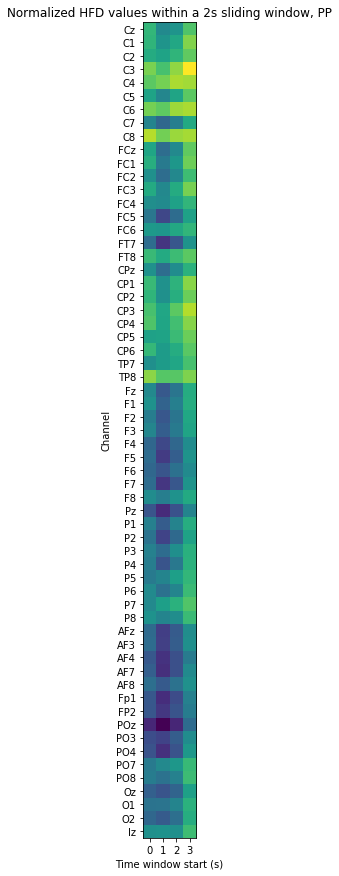

In [43]:
plt.figure(figsize=[15,15])
plt.title('Normalized HFD values within a 2s sliding window, PP')
plt.ylabel('Channel')
plt.yticks(ticks=range(61), labels=channels)
plt.xticks(range(4))
plt.xlabel('Time window start (s)')
plt.imshow(np.mean(pp_all_windows_repetitions, axis=1).transpose())
plt.savefig('./results/graphs/window_pp.eps')
plt.savefig('./results/graphs/window_pp.jpg')

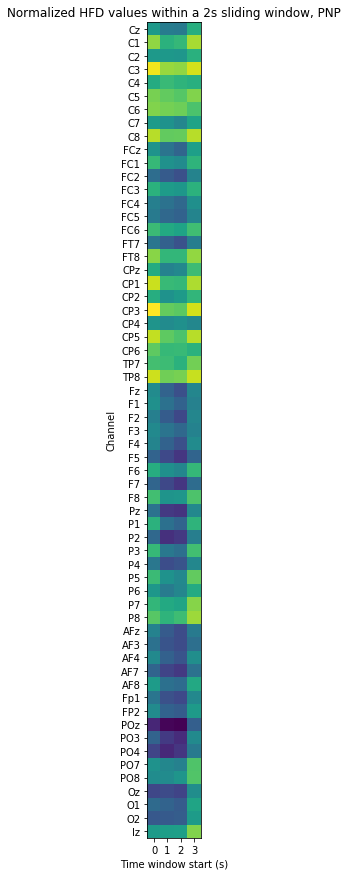

In [44]:
plt.figure(figsize=[15,15])
plt.title('Normalized HFD values within a 2s sliding window, PNP')
plt.ylabel('Channel')
plt.yticks(ticks=range(61), labels=channels)
plt.xticks(range(4))
plt.xlabel('Time window start (s)')
plt.imshow(np.mean(pnp_all_windows_repetitions, axis=1).transpose())
plt.savefig('./results/graphs/window_pnp.eps')
plt.savefig('./results/graphs/window_pnp.jpg')

In [27]:
pnp_rh[0].shape

(50, 61, 1)

In [ ]:
pp_rh[3].shape

In [ ]:
pp_and_pnp = np.concatenate((pp_rh, pnp_rh))
pp_and_pnp.shape

It's time to learn

In [19]:
log_proc_method = 'HFD'
log_dataset = 'PP/PNP-RH'
log_db_name = 'log.db'

log_notes = {'window start': window_start_sec, 'window size': window_size, 'k': k}

In [35]:
nu = 0.652008
channels = [12, 16]

acc, sensitivity, specificity, avg_acc = classify_nusvm_cross_valid(pp_rh, pnp_rh, nu, channels, ch_names,
                                                                    log_db_name=log_db_name,
                                                                    log_txt=True,
                                                                    log_proc_method=log_proc_method,
                                                                    log_dataset=log_dataset,
                                                                    log_notes=log_notes,
                                                                    log_details=False
                                                                   )
print('Accuracy', acc)
print('Sensitivity', sensitivity)
print('Specificity', specificity)
print('Average accuracy', avg_acc)

Test index 0 Preparing to classify set of 473 PP and 473 PNP.
Train score: 0.5211416490486258   Test score: 0.9298245614035088
Test index 1 Preparing to classify set of 473 PP and 473 PNP.
Train score: 0.5200845665961945   Test score: 0.7017543859649122
Test index 2 Preparing to classify set of 471 PP and 473 PNP.
Train score: 0.4703389830508475   Test score: 0.576271186440678
Test index 3 Preparing to classify set of 476 PP and 473 PNP.
Train score: 0.5310853530031612   Test score: 1.0
Test index 4 Preparing to classify set of 479 PP and 473 PNP.
Train score: 0.5241596638655462   Test score: 1.0
Test index 5 Preparing to classify set of 472 PP and 473 PNP.
Train score: 0.5026455026455027   Test score: 1.0
Test index 6 Preparing to classify set of 474 PP and 473 PNP.
Train score: 0.515311510031679   Test score: 1.0
Test index 7 Preparing to classify set of 498 PP and 473 PNP.
Train score: 0.4799176107106076   Test score: 0.96875
Test index 8 Preparing to classify set of 478 PP and 473 

In [ ]:
previous_channels=[17, 17, 24]
nu = 0.7

max_acc = {'index': 0, 'value': 0}
for channel in range(61):        
    accuracy, sensitivity, specificity, avg_accuracy = classify_nusvm_cross_valid(pp_rh, pnp_rh, nu, 
                                                                                  previous_channels + [channel], 
                                                                                  verbose=False,
                                                                                  log_db_name=log_db_name,
                                                                                  log_txt=True,
                                                                                  log_proc_method=log_proc_method,
                                                                                  log_dataset=log_dataset,
                                                                                  log_notes=log_notes
                                                                                 )
    print(channel, accuracy, sensitivity, specificity, avg_accuracy)
        
    if accuracy > max_acc['value']:
        max_acc['index'] = channel
        max_acc['value'] = accuracy

print('Max accuracy:', max_acc['index'], max_acc['value'])

In [ ]:
channels = [17, 17, 24]

max_acc = {'index': 0, 'value': 0}
for param in np.arange(0.1, 0.8, 0.001):    
    accuracy, sensitivity, specificity, avg_accuracy = classify_nusvm_cross_valid(pp_rh, pnp_rh, param,
                                                                                  channels,
                                                                                  verbose=False, 
                                                                                  log_db_name=log_db_name,
                                                                                  log_txt=True,
                                                                                  log_proc_method=log_proc_method,
                                                                                  log_dataset=log_dataset,
                                                                                  log_notes=log_notes
                                                                                 ) 
                                                      

    print(param, accuracy, sensitivity, specificity, avg_accuracy)
        
    if accuracy > max_acc['value']:
        max_acc['index'] = param
        max_acc['value'] = accuracy

        
print('Max accuracy:', max_acc['index'], max_acc['value'])

In [28]:
best_acc = classify_nusvm_param_seach(pp_rh, pnp_rh, 0.1, 0.81, 0.025, log_txt=True, log_proc_method=log_proc_method,
                                                                                  log_dataset=log_dataset,
                                                                                  log_notes=log_notes)

nu: 0.1
[11] 0.73
[11, 46] 0.77
[11, 46] 0.77
Mac Accuracy: {'channels': [11, 46], 'value': 0.7666999002991027, 'nu': 0.1}
nu: 0.125
[12] 0.74
[12] 0.74
Mac Accuracy: {'channels': [11, 46], 'value': 0.7666999002991027, 'nu': 0.1}
nu: 0.15
[52] 0.69
[52] 0.69
Mac Accuracy: {'channels': [11, 46], 'value': 0.7666999002991027, 'nu': 0.1}
nu: 0.175
[0] 0.77
[0] 0.77
Mac Accuracy: {'channels': [0], 'value': 0.7686939182452642, 'nu': 0.175}
nu: 0.19999999999999998
[25] 0.70
[25] 0.70
Mac Accuracy: {'channels': [0], 'value': 0.7686939182452642, 'nu': 0.175}
nu: 0.22499999999999998
[17] 0.72
[17] 0.72
Mac Accuracy: {'channels': [0], 'value': 0.7686939182452642, 'nu': 0.175}
nu: 0.24999999999999997
[36] 0.68
[36, 15] 0.69
[36, 15] 0.69
Mac Accuracy: {'channels': [0], 'value': 0.7686939182452642, 'nu': 0.175}
nu: 0.27499999999999997
[39] 0.67
[39] 0.67
Mac Accuracy: {'channels': [0], 'value': 0.7686939182452642, 'nu': 0.175}
nu: 0.29999999999999993
[54] 0.67
[54] 0.67
Mac Accuracy: {'channels': [

In [29]:
best_acc

{'channels': [20], 'value': 0.810568295114656, 'nu': 0.3999999999999999}